# Cargar librerias a utilizar

In [1]:
# --- Librerías estándar y científicas ---
import numpy as np  # Manipulación de arreglos numéricos de N dimensiones
import matplotlib.pyplot as plt  # Creación de gráficos y visualizaciones
import matplotlib.colors as colors  # Manejo avanzado de mapeos de colores en gráficos
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Control preciso del layout de los ejes en figuras matplotlib
from scipy.optimize import curve_fit  # Ajuste de curvas a funciones definidas
from scipy.spatial import cKDTree
import pandas as pd
import seaborn as sns

# --- Astropy: manejo de datos astronómicos ---
from astropy import units as u  # Manejo de unidades físicas
from astropy.coordinates import SkyCoord, match_coordinates_sky  # Manejo de coordenadas celestes y emparejamiento en el cielo
from astropy.io import fits  # Lectura y escritura de archivos FITS
from astropy.nddata import Cutout2D  # Extracción de recortes 2D de imágenes
from astropy.stats import sigma_clipped_stats  # Estadísticas robustas con eliminación sigma-clipping
from astropy.wcs import WCS  # Manejo de información de coordenadas WCS (World Coordinate System)
from astropy.table import QTable

# --- Photutils: detección y fotometría de fuentes ---
from photutils.detection import DAOStarFinder  # Detección de estrellas usando el algoritmo DAO
from photutils.aperture import CircularAperture, aperture_photometry  # Fotometría mediante aperturas circulares
from photutils.detection import find_peaks

# --- Astroquery: acceso a catálogos astronómicos ---
from astroquery.gaia import Gaia  # Consulta del catálogo Gaia usando ADQL


# Star Finder to PSF

In [2]:
# --- Configuración inicial ---
# Directorios
DIR = ''
OUTPUT_DIR = DIR + 'output/'

# Nombre del archivo fuente
filename = 'PSJ1606_muse_simple_X_zapped.fits'

# --- Lectura del cubo de datos FITS ---
with fits.open(DIR + filename) as hdul:
    cube = hdul[1].data           # Cubo de datos científicos
    vcube = hdul[2].data          # Varianza (para calcular errores)
    header = hdul[1].header       # Encabezado con información WCS

# WCS 2D para coordenadas espaciales
wcs_2d = WCS(header, naxis=2)

# Imagen de luz blanca (suma a lo largo del eje espectral)
white_img = np.nansum(cube, axis=0)
white_img_err = np.sqrt(np.nansum(vcube, axis=0))

# Vector de longitud de onda observado (en Å)
wave_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']

# Espectro total sumando sobre las dos dimensiones espaciales
#spectrum = np.nansum(cube, axis=(1, 2))

# --- Cálculo de límites en coordenadas celestes ---
ny, nx = cube.shape[1:]
corners_x = [0, nx]
corners_y = [0, ny]

# Transformar píxeles de las esquinas a coordenadas RA/Dec
ra_dec = wcs_2d.pixel_to_world([corners_x[0], corners_x[1], corners_x[0], corners_x[1]],
                               [corners_y[0], corners_y[0], corners_y[1], corners_y[1]])

# Límites de la región en grados
ra_min, ra_max = ra_dec.ra.deg.min(), ra_dec.ra.deg.max()
dec_min, dec_max = ra_dec.dec.deg.min(), ra_dec.dec.deg.max()

# --- Consulta ADQL a Gaia ---
# Se usa un límite de magnitud (G < 19) para restringir a estrellas relativamente brillantes
# astrometric_params_solved > 3: buena solución astrométrica
# classprob_dsc_combmod_star > 0.5: probabilidad de ser estrella

query = f"""
SELECT TOP 10
    source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE ra BETWEEN {ra_min} AND {ra_max}
  AND dec BETWEEN {dec_min} AND {dec_max}
  AND phot_g_mean_mag < 22
  AND astrometric_params_solved > 3
  AND classprob_dsc_combmod_star > 0.5
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_results = job.get_results()
print(gaia_results, "\n")


     source_id              ra                 dec         phot_g_mean_mag
                           deg                 deg               mag      
------------------- ------------------ ------------------- ---------------
6242307018500802048 241.51482538958737 -23.556558458360637       15.671239
6242307048556613376 241.49989742785178   -23.5628218960989       17.557453
6242307082916379008 241.50788684016024  -23.55287888154344       17.780014
6242307052852617856  241.4907407490663 -23.559823599740504       18.049698
6242307048557549056 241.49276723423299 -23.567343122887138       18.302149
6242307014196859904 241.51405830984802  -23.56828658714226        18.61709
6242307014196860032 241.51562384550382   -23.5687570005305       18.916084
6242307048556628096 241.49036667441862  -23.55697362007846       18.920118
6242307396457927808 241.51372455488635  -23.55069310126085       19.144053
6242307289074827776 241.49273418403286 -23.545222009136292       19.292034 



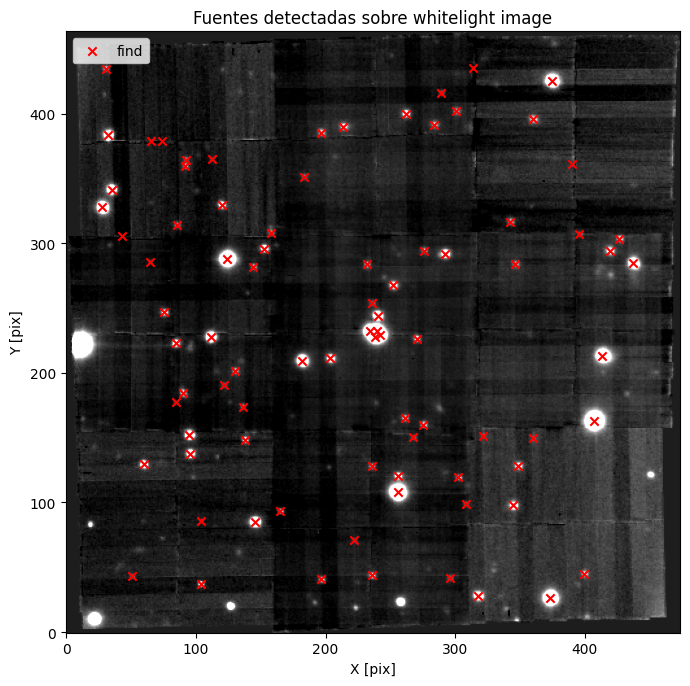

In [3]:

# --- Detección de fuentes con DAOStarFinder ---
# Se usa un umbral de 3 sigma sobre la mediana

mean, median, std = sigma_clipped_stats(white_img, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.0 * std)
sources = daofind(white_img - median)

# Coordenadas (x, y) de las fuentes detectadas
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# --- Filtro para excluir fuentes cerca del borde ---
# Elimina detecciones a menos de X px del borde
MARGIN = 25
inside_mask = (
    (positions[:, 0] > MARGIN) & (positions[:, 0] < nx - MARGIN) &
    (positions[:, 1] > MARGIN) & (positions[:, 1] < ny - MARGIN)
)
positions = positions[inside_mask]

# --- Visualización de la imagen y fuentes detectadas ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))
plt.scatter(positions[:, 0], positions[:, 1], marker='x', color='red', label='find')
plt.title('Fuentes detectadas sobre whitelight image')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')
plt.legend(loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()


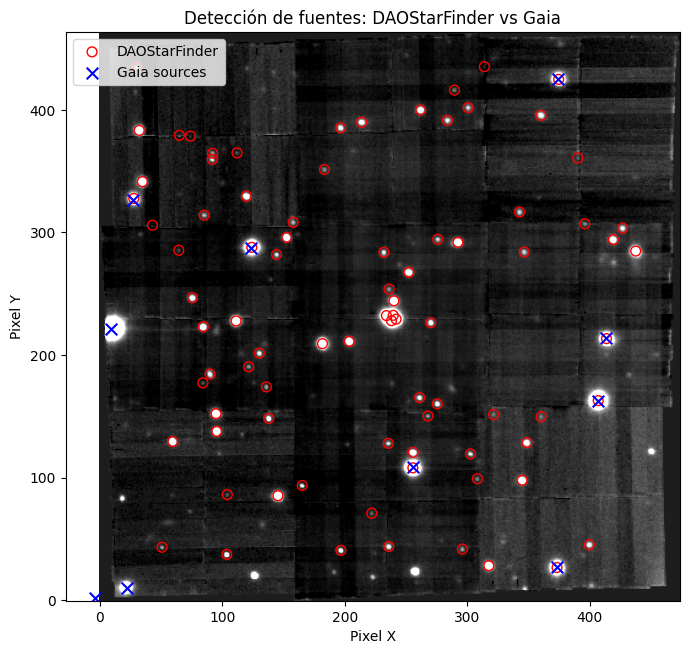

In [4]:
# --- Transformar coordenadas de GAIA (RA, Dec) a píxeles ---

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
gaia_pixels = wcs_2d.world_to_pixel(gaia_coords_corr)


# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(positions[:, 0], positions[:, 1], s=50, edgecolor='red', facecolor='none', marker='o', label='DAOStarFinder')

# Fuentes Gaia transformadas (azul)
plt.scatter(gaia_pixels[0], gaia_pixels[1], s=70, color='blue', marker='x', label='Gaia sources')

plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes: DAOStarFinder vs Gaia')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Number of matches: 7

Number of clean matches: 5

[[373.21030579  26.57237514]
 [406.78734554 162.74561609]
 [413.52051692 213.32342591]
 [124.14649836 287.81265587]
 [374.49381479 424.83183647]]
 ID     img_RA_deg        img_Dec_deg    
--- ------------------ ------------------
  1 241.49306874348522 241.49306874348522
  2 241.49103391434213 241.49103391434213
  3  241.4906259593612  241.4906259593612
  4  241.5081635797751  241.5081635797751
  5 241.49299156223728 241.49299156223728


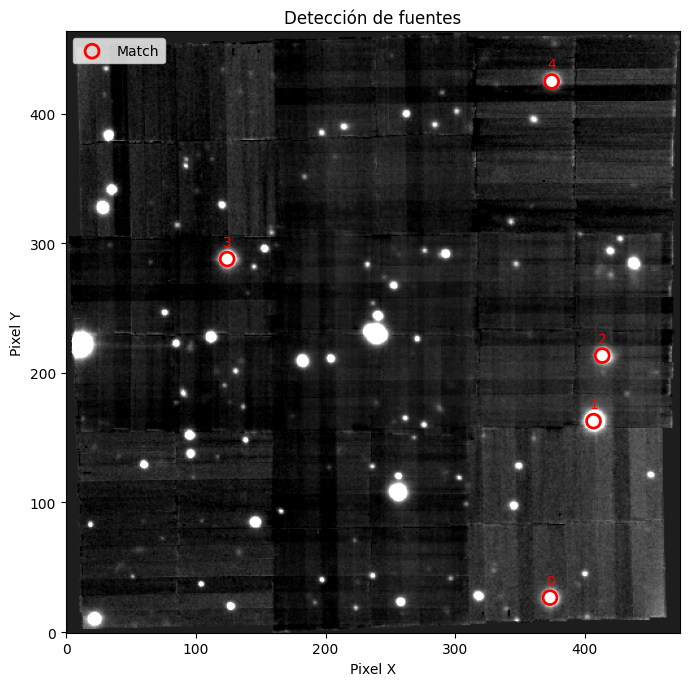

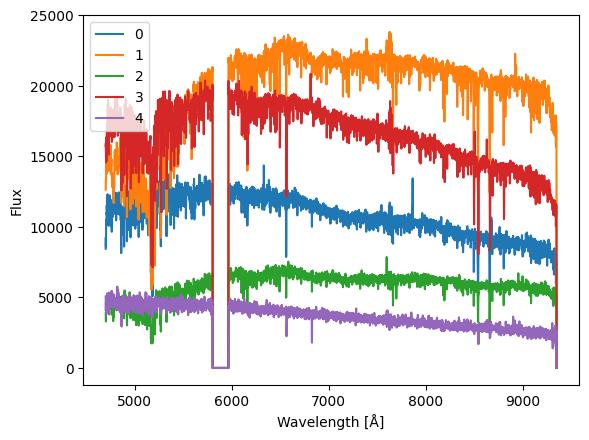

In [39]:
# --- Transformación pixeles a coordenadas celestes (fuentes encontradas) ---
sources_sky_coords = wcs_2d.pixel_to_world(positions[:, 0], positions[:, 1])

# --- Cruce de posiciones con Gaia ---
#gaia_coords = SkyCoord(ra=gaia_results['ra'], dec=gaia_results['dec'], unit='deg')

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
idx, d2d, _ = match_coordinates_sky(sources_sky_coords, gaia_coords_corr)

# Selecciona coincidencias dentro de 2 arcsec
MATCH_RADIUS = 2.0 * u.arcsec
matched = d2d <= MATCH_RADIUS

print(f"Number of matches: {np.sum(matched)}\n")

# Obtener posiciones y coordenadas coincidentes
matched_positions = positions[matched]
matched_coords = sources_sky_coords[matched]
#stars_coords = np.column_stack((matched_coords.ra.deg, matched_coords.dec.deg))
#print(matched_coords, "\n")
#print(" ")
#matched_coords_gaia = gaia_coords_corr[idx[matched]]
#print(matched_coords_gaia, "\n")


# Usar TODAS las detecciones (positions) para filtrar objetos cercanos
tree_all = cKDTree(positions)
distances, _ = tree_all.query(matched_positions, k=2)  # para cada matched, obtener vecino más cercano
nearest_neighbor_dist = distances[:, 1]

min_sep_pixels = 20  # umbral en píxeles para considerar que una estrella está contaminada
isolated_mask = nearest_neighbor_dist > min_sep_pixels

matched_positions_nocont = matched_positions[isolated_mask]
matched_coords_nocont = matched_coords[isolated_mask]

print(f"Number of clean matches: {len(matched_coords_nocont)}\n")


print(matched_positions_nocont)

# --- Tabla ordenada con los datos emparejados sin contaminacion -- 
matched_table = QTable()
matched_table['ID'] = np.arange(1, np.sum(isolated_mask)+1)
matched_table['img_RA_deg'] = matched_coords_nocont.ra.deg
matched_table['img_Dec_deg'] = matched_coords_nocont.ra.deg
print(matched_table)



# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(matched_positions_nocont[:, 0], matched_positions_nocont[:, 1], s=100,linewidths=2, edgecolor='red', facecolor='none', marker='o', label='Match')
for i, (x, y) in enumerate(matched_positions_nocont):
    plt.text(x, y + 10, str(i), color='red', fontsize=10, ha='center')


plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



# --- Espectros de las estrellas tomadas ---

pixel_scale = 0.2  # arcsec/pixel
aperture_radius_pix = 1 / pixel_scale

for i, pos in enumerate(matched_positions_nocont):
    y, x = int(pos[1]), int(pos[0])
    yy, xx = np.ogrid[:cube.shape[1], :cube.shape[2]]
    mask = (xx - x)**2 + (yy - y)**2 <= aperture_radius_pix**2
    spectrum_obj = np.nansum(cube[:, mask], axis=1)
    plt.plot(wave_obs, spectrum_obj, label=f'{i}')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.legend()
plt.show()

# PSF and object treatmen


## Metodo artesanal de PSF

### Funciones de utilidad

In [55]:
# Some useful functions:
# Get an azimuthal-averaged radial profile by using some radial coordinates
def radial_prof(img, rcoord, width=1.0, model=None, check_zeros=True):    # width cambiado de 2 a 1
    if check_zeros:
        zeros = img == 0
        img[zeros] = np.nan
        
        if model is not None:
            model[zeros] = np.nan

    rcoord_norm = rcoord // width
        
    r_arr, prof_arr, model_arr = [], [], []
    for r in np.unique(rcoord_norm):            
        sel = rcoord_norm == r
        
        img_sel = img[sel]
        if len(img_sel) < 1:  # just in case only one pixel is selected.
            continue
        
        r_arr.append(r)
        prof_arr.append(np.nanmean(img_sel))
        
        if model is not None:
            model_arr.append(np.nanmean(model[sel]))
        
    if model is None:
        model_arr = np.nan    
    
    return np.array(r_arr), np.array(prof_arr), np.array(model_arr)

# Two-dimensional (circular) Moffat profile
def moffat2D(coord, *params): # params: x0, y0, fwhm, beta, amplitude

    x, y = coord
    x0, y0, amplitude, fwhm, beta, = params

    alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
    r2 = (x - x0)**2 + (y - y0)**2
    model = amplitude / (1 + r2/alpha**2)**beta
    
    return model.ravel()

# 2D Sersic model. Could be useful.
def sersic2D(coord, pars):
    x, y = coord
    x0, y0, PA, Q, I0, Re, n = pars 
    
    xr = (x-x0) * np.cos(PA) + (y-y0) * np.sin(PA)
    yr = -(x-x0) * np.sin(PA) + (y-y0) * np.cos(PA)
    R = np.sqrt(xr**2 + (yr/Q)**2)
    
    bn = 2*n-0.333
    z = I0 * np.exp(-bn * (R/Re)**(1/n))
    
    return z.ravel()

# Fit the lensed qso image. It assumes a moffat2D function is called.
def lens_qso_fit(coord, *params):

    z = np.zeros(np.shape(coord[0])).ravel()
    for i in range(0, len(params), 5):
        
        subparams = params[i:i+5]
        z += moffat2D(coord, *subparams)
        
    #z += sersic2D(coord, params[-7:])
    
    return z

# Auxiliar plot function
def do_imshow_plot(img, mod, res, Npars=0, ncols=3, mask=None, title=None):
    # Ploting cutout image and model
    fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols,3))

    minval = np.nanmin(img) # to re-scale and not consider negative values
    if mask is not None:
        p = np.nanpercentile(img[mask]-minval, [16, 99.5]) # to normalize color scale
    else:
        p = np.nanpercentile(img-minval, [16, 99.5])
               
    col_norm=colors.LogNorm(vmin=p[0], vmax=p[1])
    
    ax[0].imshow(img-minval, origin='lower', norm=col_norm)
    ax[1].imshow(mod-minval, origin='lower', norm=col_norm)
    
    im = ax[2].imshow(res, origin='lower', vmin=-5, vmax=5, cmap='RdBu_r')
        
    # color bar for residuals
    cax = fig.add_axes([0.69, 0.24, 0.075, 0.025])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
    cbar.ax.set_xticklabels([r'-5$\sigma$', '0', r'5$\sigma$'])
    
    # some text
    ax[0].text(0.02, 0.9, 'Star', color='w', transform=ax[0].transAxes)
    ax[1].text(0.02, 0.9, 'Model', color='w', transform=ax[1].transAxes)
    ax[2].text(0.02, 0.9, 'Residuals', color='k', transform=ax[2].transAxes)
    
    if mask is not None:    
        chi2_r = np.nansum(res**2) / (img.size-Npars)      # reduced chi-square value
    else:
        chi2_r = np.nansum(res[mask]**2) / (img[mask].size-Npars)

    ax[1].text(0.6, 0.9, r'$\chi^2_\nu = $'+format(chi2_r,'.5f'), 
                          color='w', 
                          transform=ax[1].transAxes)
    
    if title is not None:
        ax[1].set_title(title)

    for i in range(ncols):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    plt.show()

    return chi2_r

### Star PSF modeling (White-Image) and normalization

C:\Users\dgch-\AppData\Local\Temp\ipykernel_17752\2064889632.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


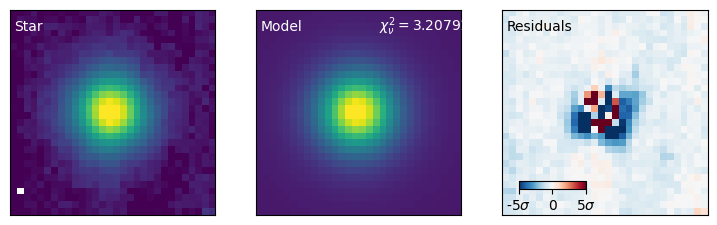

Star 0:
  x0 = 14.208
  y0 = 14.538
  amplitude = 1.124e+00
  FWHM = 3.153
  beta = 2.417
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 2.1815982e+06  1.2849004e+06  5.7665462e+05  2.4194223e+05
  1.0225636e+05  4.6277371e+04  2.3360895e+04  1.3138411e+04
  6.9848262e+03  3.7632603e+03  1.7446888e+03  2.0519183e+02
 -5.3473138e+02 -1.1713383e+03 -1.5434821e+03 -1.8560883e+03
 -1.8143817e+03 -1.5324172e+03 -1.6550959e+03 -1.8815845e+03
 -2.0999707e+02]
 
  fit_prof = [2.22668150e+06 1.25691862e+06 5.82981250e+05 2.58960734e+05
 1.13473945e+05 5.22926562e+04 2.64863867e+04 1.48782363e+04
 8.73069629e+03 5.30775781e+03 3.38602930e+03 2.24841406e+03
 1.53090259e+03 1.06487708e+03 7.63185791e+02 5.74026306e+02
 4.26894012e+02 3.21358154e+02 2.45145920e+02 1.91389175e+02
 1.57923630e+02]


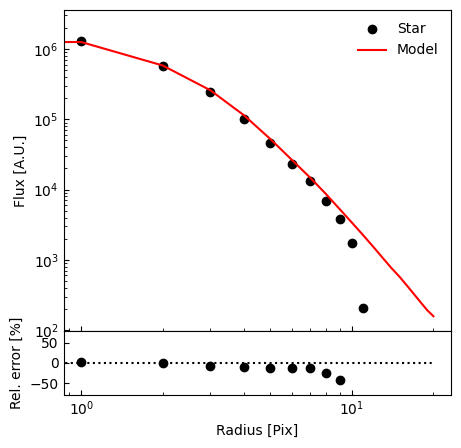

C:\Users\dgch-\AppData\Local\Temp\ipykernel_17752\2064889632.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


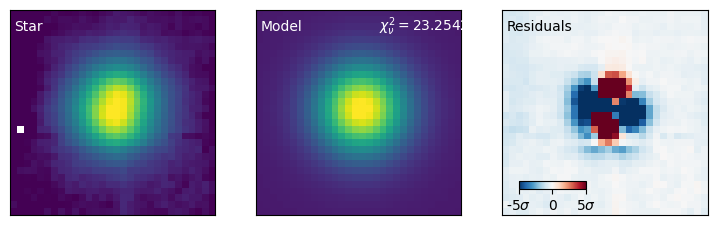

Star 1:
  x0 = 14.884
  y0 = 14.985
  amplitude = 1.016e+00
  FWHM = 4.282
  beta = 2.942
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 2.8773800e+06  2.1991880e+06  1.3504645e+06  7.1548619e+05
  3.2035922e+05  1.5108002e+05  7.1022617e+04  3.7799645e+04
  2.1065705e+04  1.1370221e+04  5.9752051e+03  2.0984885e+03
 -3.2493491e+02 -1.6100859e+03 -3.1968496e+03 -3.2509897e+03
 -3.8987834e+03 -3.3022422e+03 -4.5925190e+03 -5.9565610e+03
 -5.3749795e+03 -5.8278911e+03]
 
  fit_prof = [2.8331282e+06 2.2110960e+06 1.3138235e+06 6.9892450e+05 3.3926922e+05
 1.6453305e+05 8.5286680e+04 4.5862129e+04 2.5651904e+04 1.4823313e+04
 8.9305137e+03 5.6147368e+03 3.6061731e+03 2.3846555e+03 1.6145691e+03
 1.1268646e+03 7.9508563e+02 5.6598419e+02 4.2085641e+02 3.1775092e+02
 2.3303293e+02 1.9521544e+02]


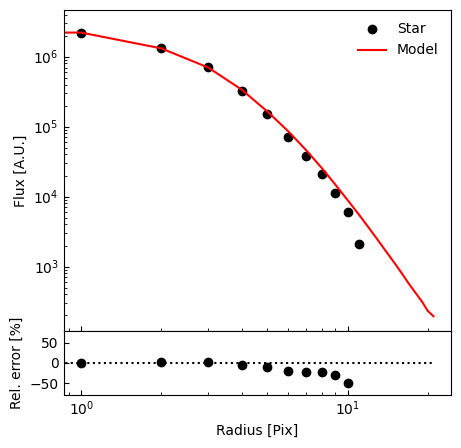

C:\Users\dgch-\AppData\Local\Temp\ipykernel_17752\2064889632.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


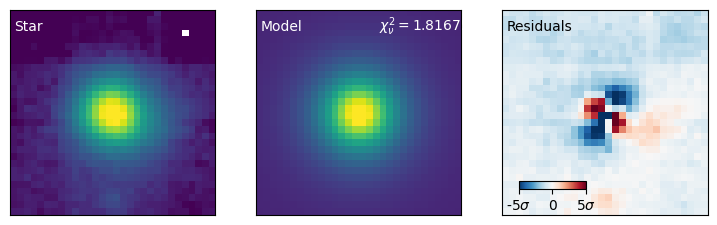

Star 2:
  x0 = 14.539
  y0 = 14.304
  amplitude = 1.136e+00
  FWHM = 3.218
  beta = 1.816
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 1.0926748e+06  6.6260175e+05  3.1715850e+05  1.4509702e+05
  6.9771164e+04  3.6552848e+04  2.1444320e+04  1.2665847e+04
  7.5101318e+03  4.3151660e+03  1.9078125e+03  8.2648071e+02
 -2.4311650e+02 -6.0457782e+02 -1.4131814e+03 -2.5368335e+03
 -3.1004014e+03 -3.9912776e+03 -3.7827959e+03 -4.4646621e+03
 -3.1590044e+03]
 
  fit_prof = [1.1094042e+06 6.4892119e+05 3.2308250e+05 1.5557716e+05 7.9212938e+04
 4.3506004e+04 2.5769139e+04 1.6465961e+04 1.0884240e+04 7.4576953e+03
 5.2716016e+03 3.8286016e+03 2.8677773e+03 2.1871101e+03 1.7044966e+03
 1.3732461e+03 1.0912354e+03 8.7988373e+02 7.2179138e+02 5.9599634e+02
 4.9765244e+02]


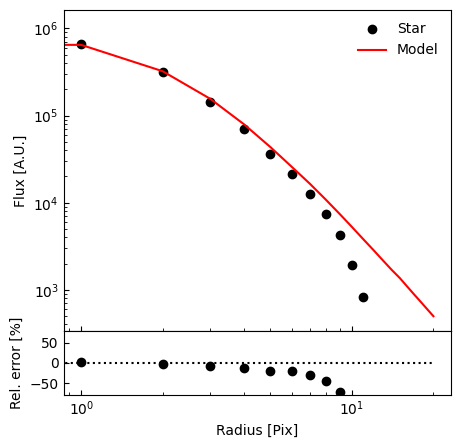

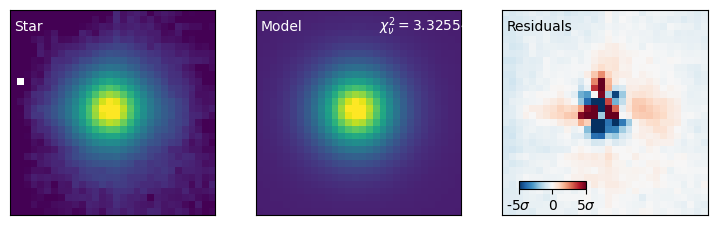

Star 3:
  x0 = 14.139
  y0 = 14.839
  amplitude = 1.051e+00
  FWHM = 2.616
  beta = 2.293
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 4.4780340e+06  2.4991098e+06  8.9926038e+05  3.2624006e+05
  1.3365447e+05  6.3202074e+04  3.3576289e+04  1.9088723e+04
  1.1241626e+04  6.7170762e+03  3.6662603e+03  1.6509391e+03
 -7.0802811e+01 -1.0786775e+03 -2.0188177e+03 -2.3056611e+03
 -2.1426184e+03 -2.8989160e+03 -2.9740217e+03 -3.7858501e+03
 -3.9016692e+03 -2.3387927e+03]
 
  fit_prof = [4.5177640e+06 2.4751740e+06 9.0731150e+05 3.2995816e+05 1.3352231e+05
 6.0781641e+04 3.1080588e+04 1.7172506e+04 1.0105887e+04 6.2329399e+03
 3.9873621e+03 2.6597693e+03 1.8407361e+03 1.3037880e+03 9.4499933e+02
 7.0727258e+02 5.2789832e+02 4.0328482e+02 3.1591751e+02 2.5065472e+02
 2.0419823e+02 1.7604561e+02]


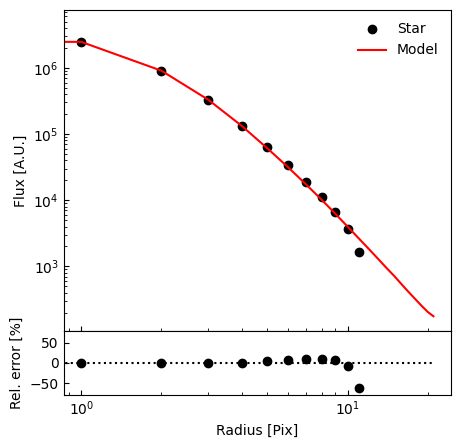

C:\Users\dgch-\AppData\Local\Temp\ipykernel_17752\2064889632.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


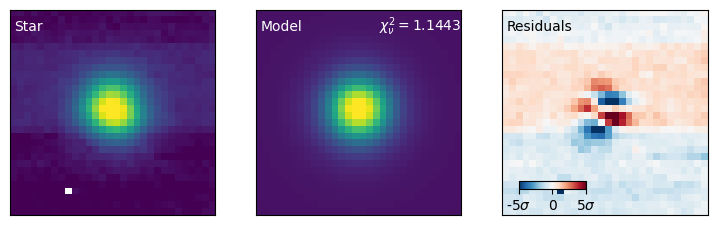

Star 4:
  x0 = 14.452
  y0 = 14.960
  amplitude = 1.031e+00
  FWHM = 4.277
  beta = 2.489
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [549000.4    403460.5    236976.02   122227.26    64388.453   34575.246
  19525.145   12429.458    7618.8706   4750.207    2570.2256   1068.9215
    637.4784   -626.426    -615.6431  -1815.3843  -2466.8894  -2721.7937
  -3275.6401  -3501.4915  -2592.637 ]
 
  fit_prof = [5.4606719e+05 4.0103078e+05 2.3762670e+05 1.2257184e+05 6.2583254e+04
 3.3666633e+04 1.8871051e+04 1.0844688e+04 6.4872100e+03 4.0274417e+03
 2.6123943e+03 1.7374644e+03 1.1924373e+03 8.3994714e+02 6.0150189e+02
 4.4367554e+02 3.2842581e+02 2.5110655e+02 1.9224690e+02 1.4776167e+02
 1.2050474e+02]


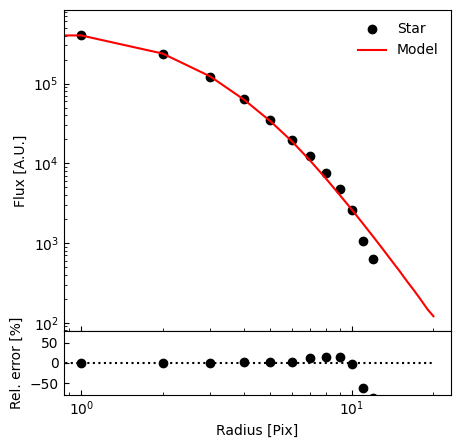

 
 
 
[[3.1528210513350414, 2.4170928171908073], [4.282393779402543, 2.9415677616425446], [3.218443886791929, 1.8157552942480386], [2.616492964663272, 2.293101441140863], [4.277040271930277, 2.488849769300072]]


In [65]:
star_radec  = np.column_stack((matched_coords_nocont.ra.deg, matched_coords_nocont.dec.deg))

FHMW_Beta_list = []
flux_list = []
images_chi2 = []

annulus_background = False

for i, (ra, dec) in enumerate(star_radec):
    
    # Crear objeto SkyCoord con RA y Dec en grados
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')


    # Definir el tamaño del recorte en pixeles
    cutout_size = 30
    #if i == len(star_radec) - 2:
    #    cutout_size = 80


    # Crear recorte en imagen de luz blanca
    cutout = Cutout2D(white_img, coord, size=cutout_size, 
                      wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img = cutout.data
    cutout_wcs = cutout.wcs
    del cutout

    # Crear recorte en imagen de error
    aux = Cutout2D(white_img_err, coord, size=cutout_size, 
                   wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img_err = aux.data
    del aux

    # -------------------------------------------------------------- #

    # Making the pixel grid that will used during the fit.
    szy, szx = np.shape(cutout_img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))


    # Avoiding pixels with 0 or NaN values 
    mask = (cutout_img == 0) | (np.isnan(cutout_img))
    x_aux = x[~mask]
    y_aux = y[~mask]

    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    norm = np.nanmax(cutout_img_aux)

    cutout_img_aux /= norm
    cutout_img_err_aux /= norm 

    # Calculate background statistics for the cutout image and
    # subtract the background. I should add the background 
    # uncertainty to the error budget, but I am *not* doing this.
    
    if annulus_background:

        szy_an, szx_an = white_img.shape
        x_an, y_an = np.meshgrid(np.arange(szx_an), np.arange(szy_an))

        xcen = matched_positions_nocont[i][0]
        ycen = matched_positions_nocont[i][1]

        radius = np.sqrt( (x_an - xcen)**2 + (y_an - ycen)**2 )
        annulus = (radius > 12) & (radius < 17)

        _, median, std = sigma_clipped_stats(white_img[annulus], sigma=3.0)

        #-------------- -------------- -------------- -------------- --------------#
        fig, ax = plt.subplots(figsize=(5,5))
        minval = np.nanmin(white_img)
        p = np.nanpercentile(white_img - minval, [16, 99.5])

        col_norm = colors.LogNorm(vmin=p[0], vmax=p[1])

        im = ax.imshow(white_img - minval, origin='lower', norm=col_norm, cmap='viridis')
        ax.contour(annulus, colors='r', linewidths=0.8)

        # barra de color
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Flux [A.U.]")

        ax.set_title("Annulus region for background estimation")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(xcen-cutout_size,xcen+cutout_size)
        ax.set_ylim(ycen-cutout_size,ycen+cutout_size)

        plt.show()

        #-------------- -------------- -------------- -------------- --------------#
    else:
        _, median, std = sigma_clipped_stats(cutout_img_aux*norm, sigma=3.0)
        #std = np.nanstd(cutout_img_aux)

    cutout_img_corr = cutout_img - median


    # Setting the initial guesses and model the star
    guess = [cutout_size/2, cutout_size/2, np.nanmax(cutout_img_corr), 2.4, 3.5]

    popt_psf, pcov_psf = curve_fit(moffat2D, 
                                   (x_aux, y_aux), 
                                   cutout_img_aux.ravel(), 
                                   p0=guess,
                                   absolute_sigma=True, 
                                   sigma=cutout_img_err_aux.ravel())
    

        
    FHMW_Beta_list.append(list(popt_psf[3:]))
    flux_list.append(popt_psf[2])



    # Obtain the best fit. Note that as I am fitting the auxiliar array
    # without zero values, I need to re-arrange the best-fit output to 
    # a 2D array following the cutout image size.
    fit_aux = moffat2D((x_aux, y_aux), *popt_psf)

    
    fit = cutout_img_corr*0
    #fit = np.full_like(cutout_img_corr, np.nan)

    
    fit[~mask] = fit_aux * norm
    
    residuals = (cutout_img_corr-fit) / std      # Residuals w.r.t. the image noise


    # Plotting images 
    chi_2 = do_imshow_plot(cutout_img_corr, fit, residuals, Npars=len(popt_psf), 
                                               mask=~mask)
    # Extracting radial profiles to provide better comparison
    radius =  np.sqrt((x-popt_psf[0])**2 + (y-popt_psf[1])**2) # circular apertures


    r_prof, img_prof, fit_prof = radial_prof(cutout_img_corr, 
                                             radius, 
                                             model=fit)
    
    print(f"Star {i}:")
    print(f"  x0 = {popt_psf[0]:.3f}")
    print(f"  y0 = {popt_psf[1]:.3f}")
    print(f"  amplitude = {popt_psf[2]:.3e}")
    print(f"  FWHM = {popt_psf[3]:.3f}")
    print(f"  beta = {popt_psf[4]:.3f}")
    print(" ")
    print("  r_prof =", r_prof)
    print(" ")
    print("  img_prof =", img_prof)
    print(" ")
    print("  fit_prof =", fit_prof)


    images_chi2.append(chi_2)

    # Plotting radial profile
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(r_prof, img_prof, 'ok', label='Star')
    ax.plot(r_prof, fit_prof, '-r', label='Model')
    
    ax.legend(frameon=False)  
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis="both", direction="in", which='both')

    ax.set_ylabel('Flux [A.U.]')

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="20%", pad=0)


    ax.figure.add_axes(ax2)
        
    ax2.plot(r_prof, 100*(1 - fit_prof/img_prof), 'ok')
    ax2.plot(r_prof, img_prof*0, ':k', linewidth=1.5)

    ax2.set_ylim([-79, 79])
    ax2.set_xscale('log')
    ax2.tick_params(axis="both", direction="in",which='both')
    
    ax2.set_ylabel('Rel. error [%]')
    ax2.set_xlabel('Radius [Pix]')
    
    plt.show()
    
    print(" ")
    print(" ")
    print(" ")

print(FHMW_Beta_list)

In [63]:
# índices deseados
indices = [0,1, 2, 3, 4]

# filtrar
sublista = [FHMW_Beta_list[i] for i in indices]

# separar valores
valores_1 = [par[0] for par in sublista]
valores_2 = [par[1] for par in sublista]

# estadísticos
prom_1 = np.mean(valores_1)
med_1 = np.median(valores_1)
std_1 = np.std(valores_1, ddof=1)

prom_2 = np.mean(valores_2)
med_2 = np.median(valores_2)
std_2 = np.std(valores_2, ddof=1)

print("FWHM:")
print(f"Promedio: {prom_1}")
print(f"Mediana: {med_1}")
print(f"Desviación estándar: {std_1}")

print("Beta:")
print(f"Promedio: {prom_2}")
print(f"Mediana: {med_2}")
print(f"Desviación estándar: {std_2}")


FWHM:
Promedio: 3.509438390824613
Mediana: 3.218443886791929
Desviación estándar: 0.7409247503817308
Beta:
Promedio: 2.391273416704465
Mediana: 2.4170928171908073
Desviación estándar: 0.40431129657727755


## Fitting del quasar (whitelight image)

### Con imagenes normalidazas y psf de la estrella


x_peak y_peak peak_value
------ ------ ----------
    28     24  1008631.3
    32     25  1229902.2
    24     28  1404201.9
    30     29   883758.2
    30     40   353617.2
    26     50   24754.11
 peak_value
-----------
  0.7177807
 0.87524563
  0.9992839
  0.6289162
 0.25164756
0.017615974


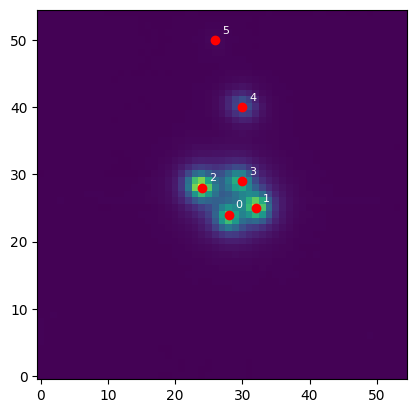

non_free:  0
non_free:  1
non_free:  2
non_free:  3
free:  4
free:  5


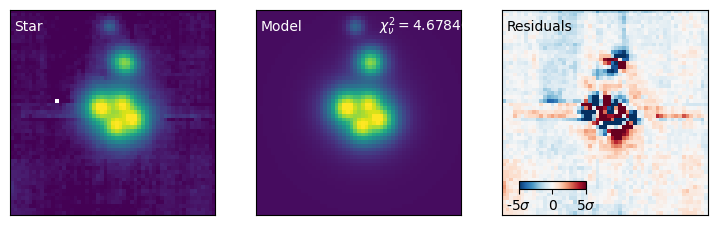

   Fuente          x          y     flujo      FWHM      beta
0       0  27.915178  23.564820  0.707927  3.152821  2.417093
1       1  32.149087  25.133603  0.861002  3.152821  2.417093
2       2  23.916787  28.158588  0.984585  3.152821  2.417093
3       3  29.498799  28.855041  0.645376  3.152821  2.417093
4       4  30.066303  40.171465  0.270305  3.245964  2.640504
5       5  26.047059  49.729677  0.017422  3.095419  5.701667


In [93]:
white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567      # Coordenadas del objeto (img. frame reference)

star_psf = FHMW_Beta_list[0]       # PSF MODEL SELECTION

cutout_size = 55    # in pixel units (Make cutout for the white-light image and its error image)


################ mask attemp ############## 

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#nan_mask = (x - 240)**2 + (y - 225)**2 <= 0.5
#white_img[nan_mask] = np.nan 

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)

#-----------------------------------------#


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 



# Avoiding pixels with 0 or NaN values 
mask = (qso_img == 0) | (np.isnan(qso_img))
x_aux = x[~mask]
y_aux = y[~mask]

qso_img_aux = qso_img[~mask]
qso_img_err_aux = qso_img_err[~mask]

norm = np.nanmax(qso_img_aux)


qso_img_aux /= norm
qso_img_err_aux /= norm 



mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
#mean, median, std = sigma_clipped_stats(qso_img_aux*norm, sigma=3.0)

qso_img -= median  # rough background subtraction


threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']

print(tbl[["x_peak", "y_peak", "peak_value"]])
print(peakval/norm)


Nsources = len(xpeak)

# Visualización rápida
plt.imshow(qso_img, origin='lower')
plt.plot(xpeak, ypeak, 'or')
for i in range(Nsources):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Construcción de parámetros iniciales y límites
guess, up_bounds, lo_bounds = [], [], []

for i in range(Nsources):
    if peakval[i]/norm < 0.3:   #0.3 deja qso fijo a psf y otros free; 0:all_non_free
        print("free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(popt_psf[3:])
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]/norm, 50.0, 50.0]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.01*peakval[i]/norm, 0.001, 0.001]
    else:
        print("non_free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(star_psf)
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.2*peakval[i]/norm] + [x * 1.00000001 for x in star_psf]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.999999999 for x in star_psf]


# Ajuste con modelo Moffat múltiple
popt, pcov = curve_fit(lens_qso_fit,
                       (x, y),
                       qso_img_aux.ravel(),
                       p0=guess,
                       sigma=qso_img_err_aux.ravel(),
                       bounds=(lo_bounds, up_bounds)
                       )

# Evaluación del modelo y visualización
fit_aux = lens_qso_fit((x, y), *popt)
fit = np.zeros_like(qso_img)
fit[~mask] = fit_aux * norm  # se escala el modelo a la imagen original

residuals = (qso_img - fit) / std  # residuo en unidades de sigma

# Gráfico final
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))

# Construcción de tabla con parámetros
param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)

# 1 2 0 3

rangos con parametros libres (no PSF based):  -------   FWHM = [3, 3.3] ------ Beta = [2.19, 3.2] ------

### Con imagenes normalidazas y psf manual



x_peak y_peak peak_value
------ ------ ----------
    28     24  1008631.3
    32     25  1229902.2
    24     28  1404201.9
    30     29   883758.2
    30     40   353617.2
    26     50   24754.11
 peak_value
-----------
  0.7177807
 0.87524563
  0.9992839
  0.6289162
 0.25164756
0.017615974


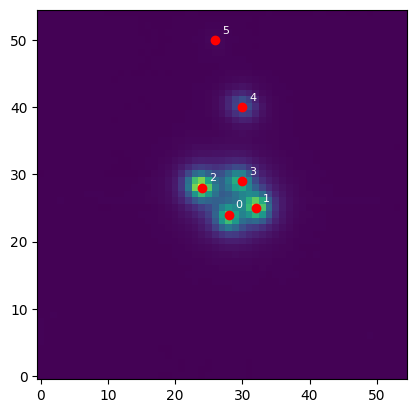

non_free:  0
non_free:  1
non_free:  2
non_free:  3
free:  4
free:  5


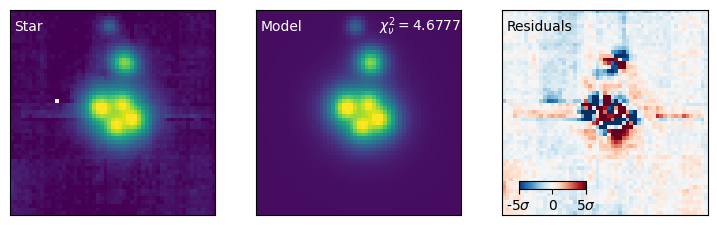

   Fuente          x          y     flujo      FWHM      beta
0       0  27.915176  23.564824  0.707917  3.152832  2.416976
1       1  32.149082  25.133605  0.860990  3.152832  2.416976
2       2  23.916779  28.158591  0.984594  3.152768  2.416976
3       3  29.498793  28.855041  0.645365  3.152832  2.416976
4       4  30.066302  40.171469  0.270303  3.245993  2.640741
5       5  26.047067  49.729662  0.017422  3.095386  5.699275


In [98]:
white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567      # Coordenadas del objeto (img. frame reference)

cutout_size = 55    # in pixel units (Make cutout for the white-light image and its error image)


################ mask attemp ############## 

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#nan_mask = (x - 240)**2 + (y - 225)**2 <= 0.5
#white_img[nan_mask] = np.nan 

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)

#-----------------------------------------#


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 


# Avoiding pixels with 0 or NaN values 
mask = (qso_img == 0) | (np.isnan(qso_img))
x_aux = x[~mask]
y_aux = y[~mask]

qso_img_aux = qso_img[~mask]
qso_img_err_aux = qso_img_err[~mask]

norm = np.nanmax(qso_img_aux)


qso_img_aux /= norm
qso_img_err_aux /= norm 


mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
#mean, median, std = sigma_clipped_stats(qso_img_aux*norm, sigma=3.0)

qso_img -= median  # rough background subtraction


threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']

print(tbl[["x_peak", "y_peak", "peak_value"]])
print(peakval/norm)


Nsources = len(xpeak)

# Visualización rápida
plt.imshow(qso_img, origin='lower')
plt.plot(xpeak, ypeak, 'or')
for i in range(Nsources):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Construcción de parámetros iniciales y límites
guess, up_bounds, lo_bounds = [], [], []
fwhm = 3.1528
beta = 2.417
for i in range(Nsources):
    if peakval[i]/norm < 0.3:   #0.3 deja qso fijo a psf y otros free; 0:all_non_free
        print("free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(popt_psf[3:])
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]/norm, 50.0, 50.0]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0, 0.001, 0.001]
    else:
        print("non_free: ", i)

        guess += [xpeak[i], ypeak[i], peakval[i]/norm, fwhm, beta ] 
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.8*peakval[i]/norm, fwhm*1.00001 , beta*1.00001]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0, fwhm*0.99999 , beta*0.99999]


# Ajuste con modelo Moffat múltiple
popt, pcov = curve_fit(lens_qso_fit,
                       (x, y),
                       qso_img_aux.ravel(),
                       p0=guess,
                       sigma=qso_img_err_aux.ravel(),
                       bounds=(lo_bounds, up_bounds)
                       )

# Evaluación del modelo y visualización
fit_aux = lens_qso_fit((x, y), *popt)
fit = np.zeros_like(qso_img)
fit[~mask] = fit_aux * norm  # se escala el modelo a la imagen original

residuals = (qso_img - fit) / std  # residuo en unidades de sigma

# Gráfico final
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))

# Construcción de tabla con parámetros
param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)

# 1 2 0 3

# Go trought wavelenght (Start test)

In [48]:
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)


## Multiframe

### test - Normalized

In [49]:
print(FHMW_Beta_list)

[[np.float64(3.1528200326906552), np.float64(2.4170880933362406)], [np.float64(4.282395669336644), np.float64(2.941573551015564)], [np.float64(3.218442542914461), np.float64(1.8157529476211671)], [np.float64(2.6164930267364164), np.float64(2.2931015402380135)], [np.float64(3.108812743998894), np.float64(2.2446961720688123)], [np.float64(4.277038417890503), np.float64(2.488843668897654)]]


<SkyCoord (ICRS): (ra, dec) in deg
    (241.49306874, -23.56806976)>
param: 12.06447273, bounds: [10.0, 20.0], in bounds: True
param: 11.84000283, bounds: [10.0, 20.0], in bounds: True
param: 1.07655817, bounds: [0.899464867193294, 1.6864966259874261], in bounds: True
param: 3.06052643, bounds: [2.522256026152524, 4.729230049035983], in bounds: True
param: 2.66879, bounds: [1.9336704746689926, 3.625632140004361], in bounds: True
----------------------------------------------------------------------------
[0,50]


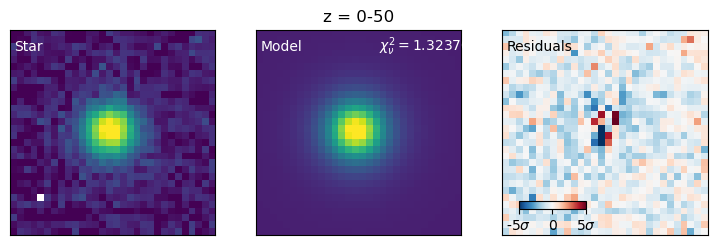

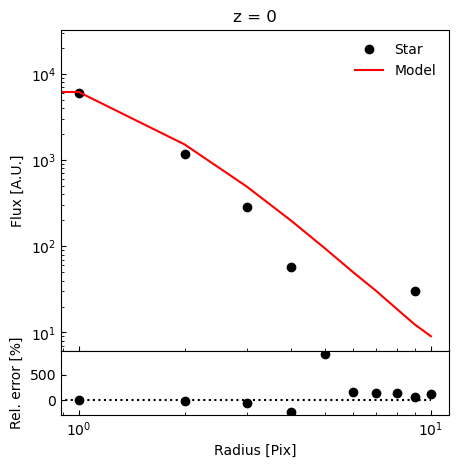

[200,250]


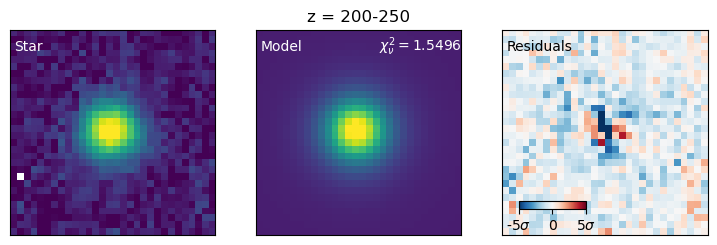

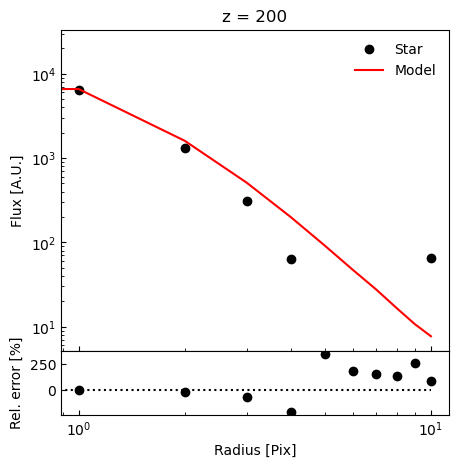

[400,450]


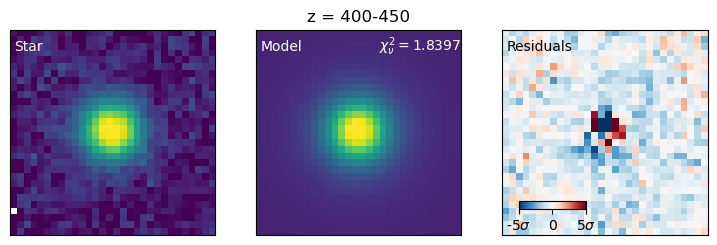

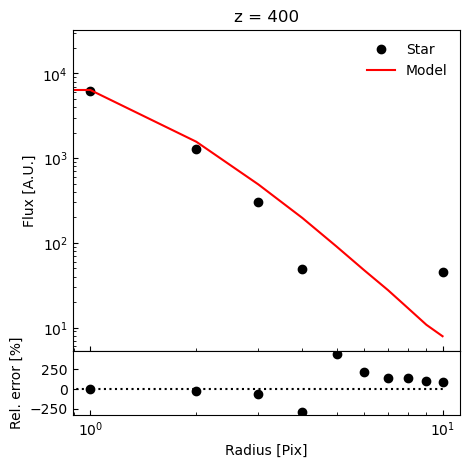

[600,650]


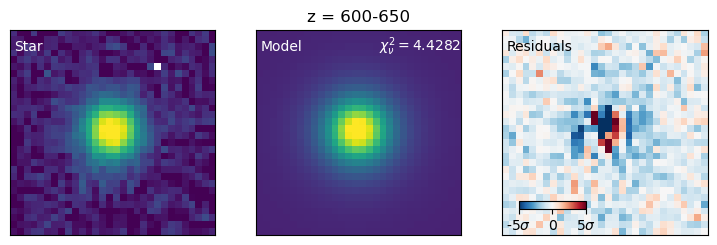

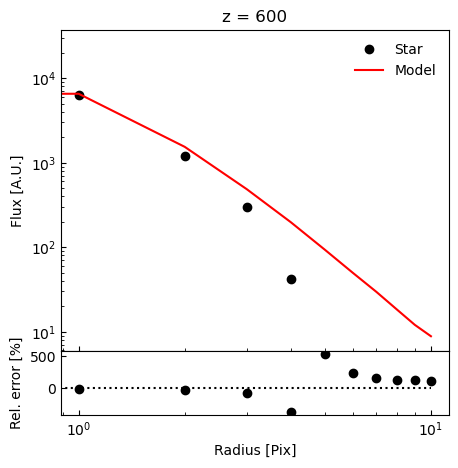

[800,850]


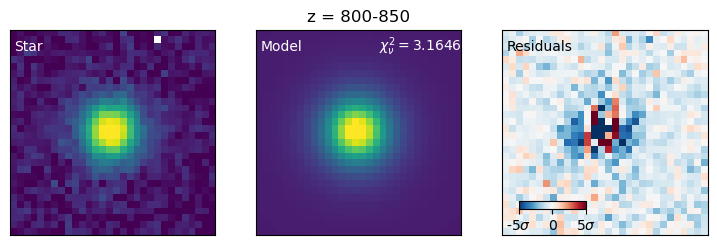

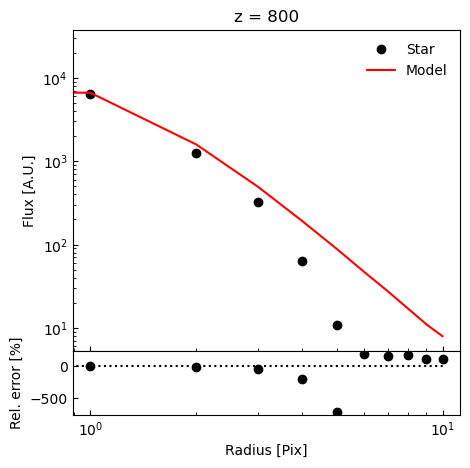

[1000,1050]


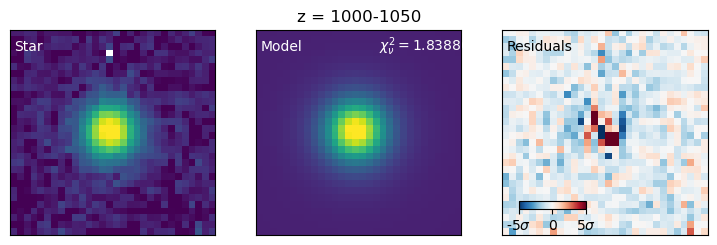

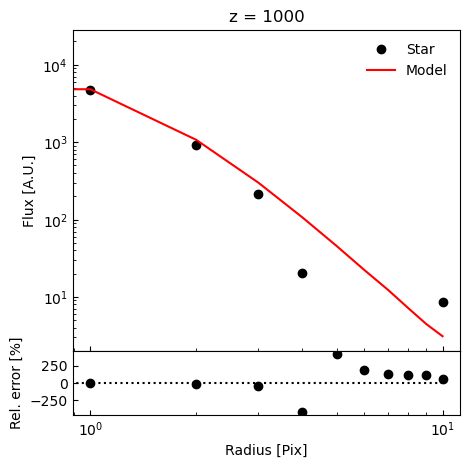

[1200,1250]


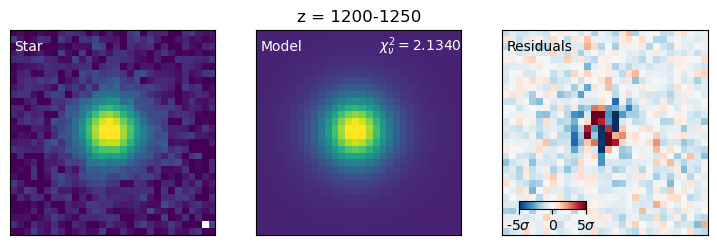

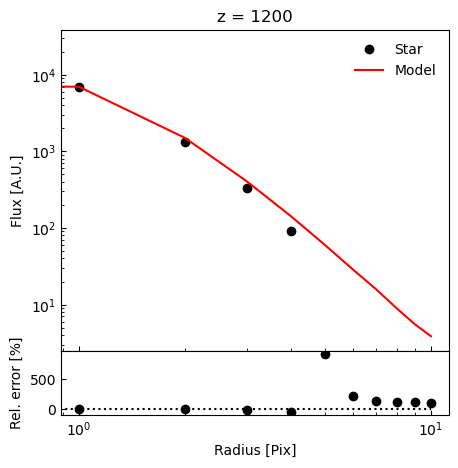

[1400,1450]


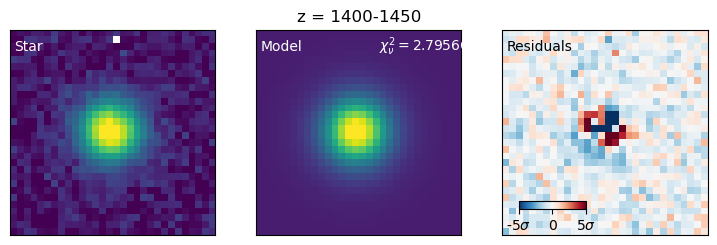

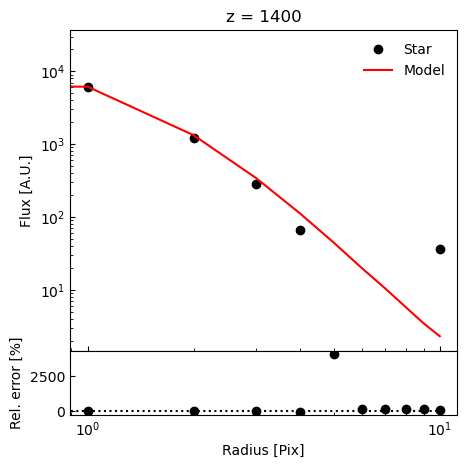

[1600,1650]


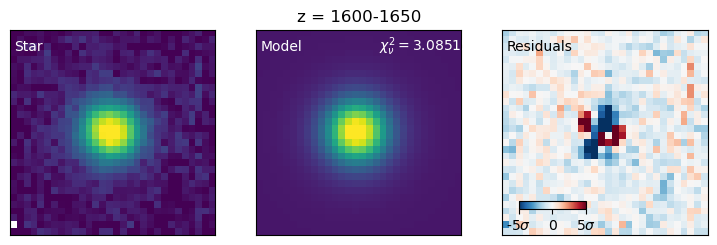

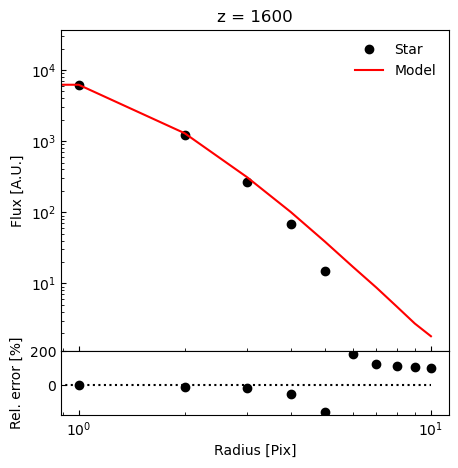

[1800,1850]


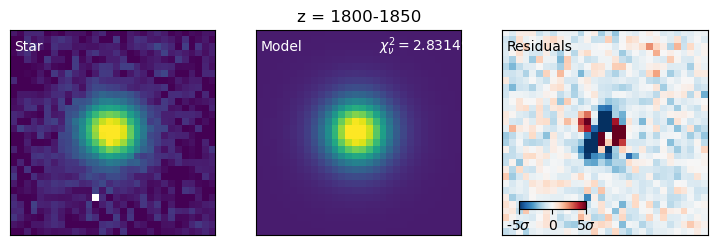

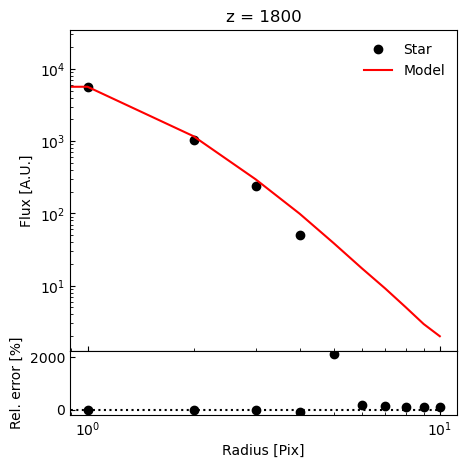

[2000,2050]


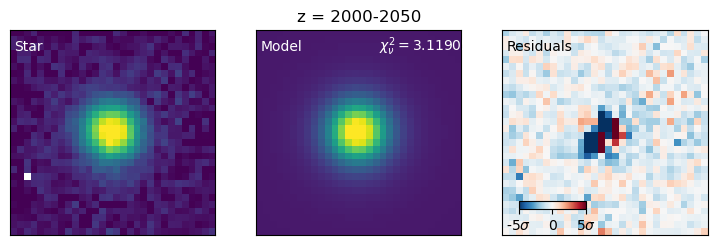

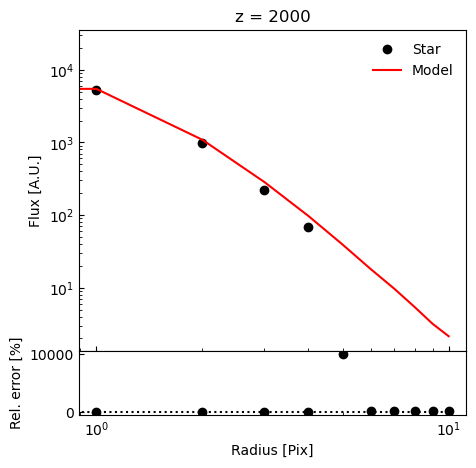

[2200,2250]


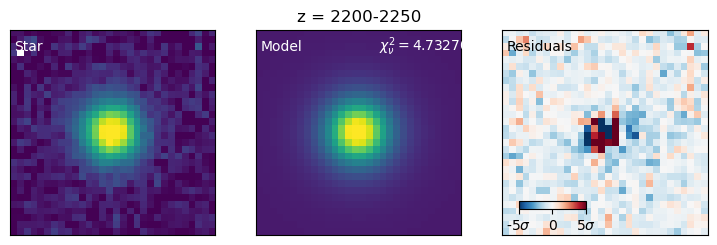

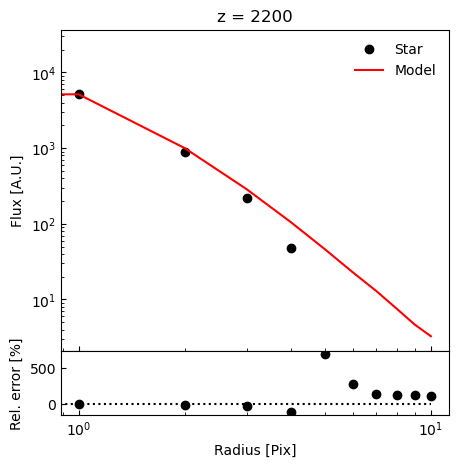

[2400,2450]


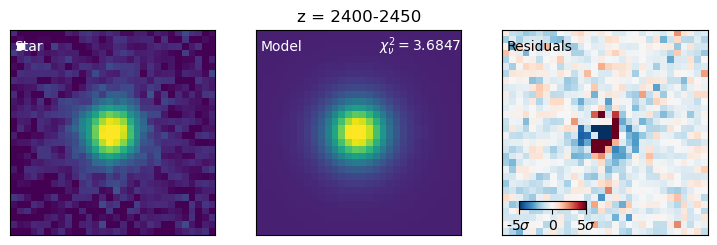

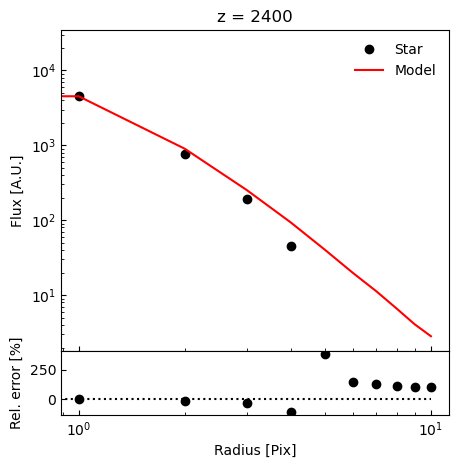

[2600,2650]


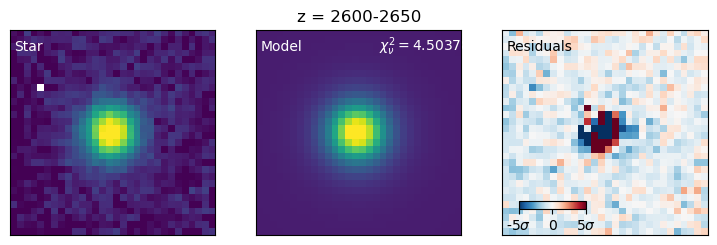

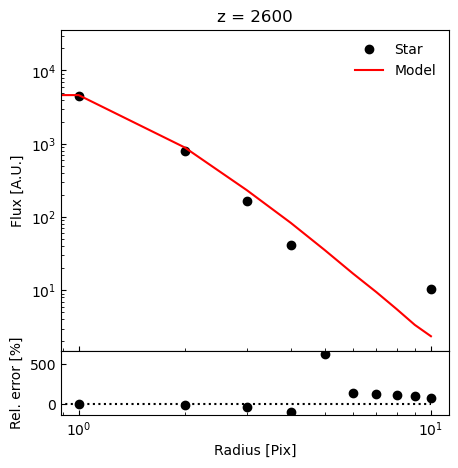

[2800,2850]


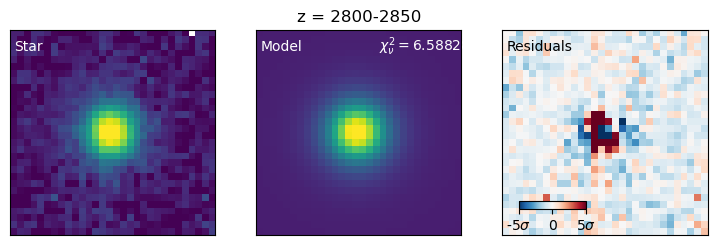

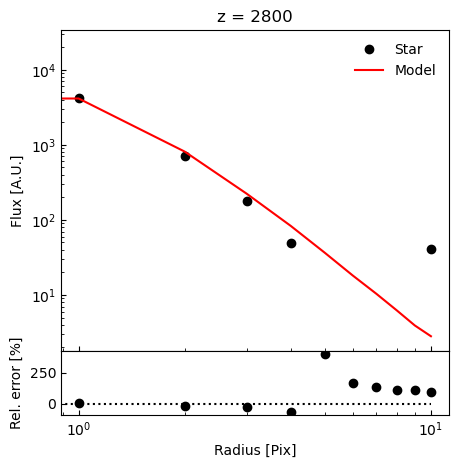

[3000,3050]


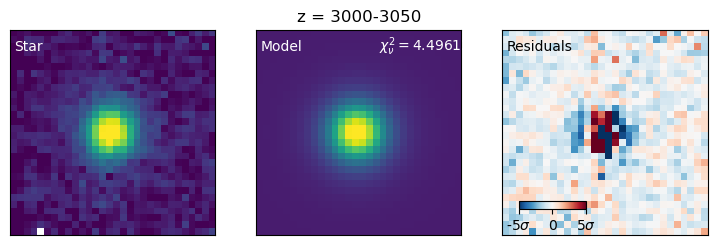

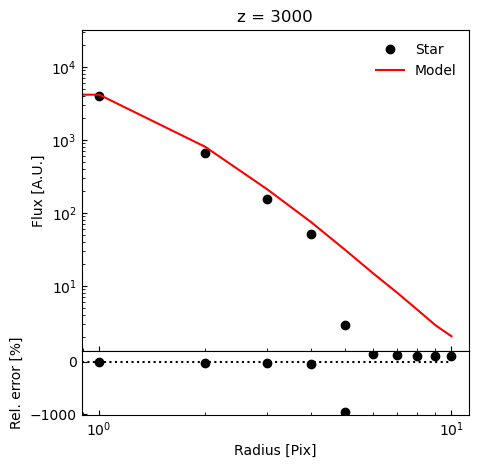

[3200,3250]


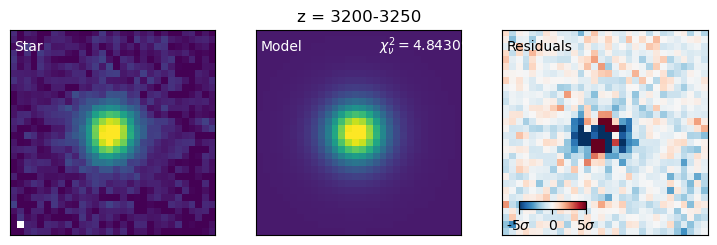

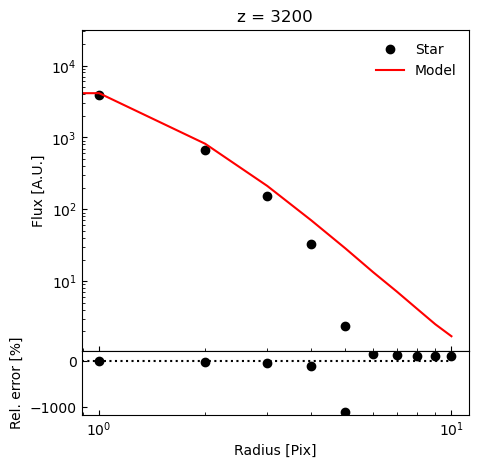

[3400,3450]


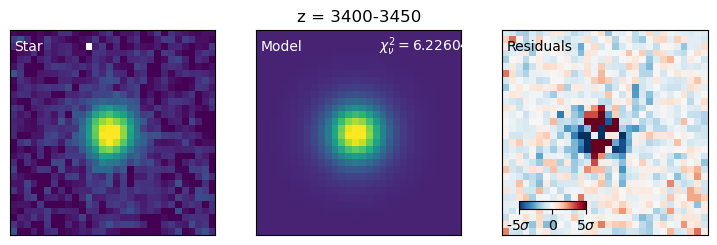

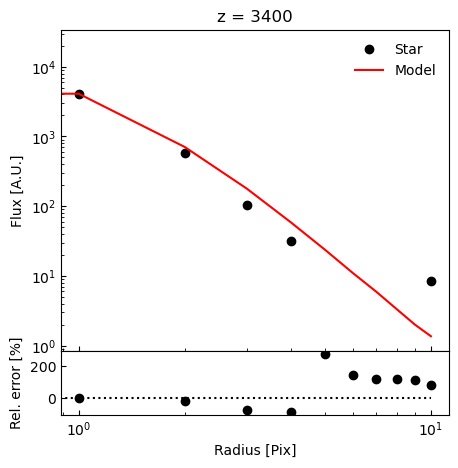

[3600,3650]


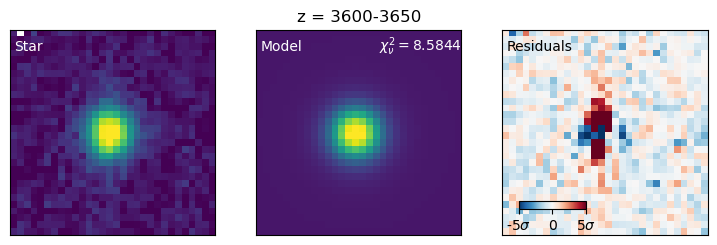

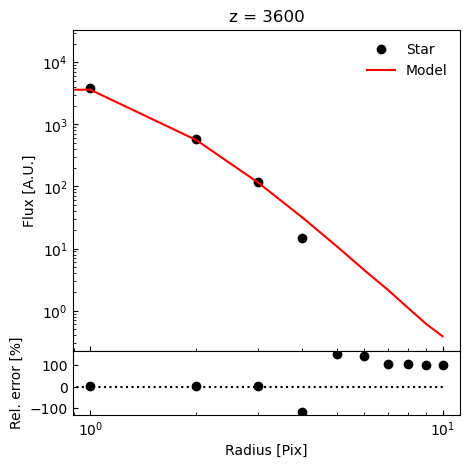

[array([14.07492003, 14.7402268 ,  1.07929785,  3.1745692 ,  1.93367047]), array([14.05726715, 14.74107918,  1.0790166 ,  3.24317079,  1.93367047]), array([14.08590344, 14.70405184,  1.08723489,  3.31801678,  1.96895169]), array([14.11537782, 14.7158605 ,  1.11032433,  3.32794324,  1.98121755]), array([14.14099545, 14.7393368 ,  1.11349606,  3.38393661,  2.05965346]), array([14.19946309, 14.72278275,  1.12988068,  3.36599665,  2.05546761]), array([14.25324112, 14.72613007,  1.09390119,  3.44478135,  2.13520875]), array([14.30692739, 14.69538256,  1.11609379,  3.37793493,  2.01318405]), array([14.32191152, 14.68463046,  1.12001773,  3.32876604,  2.04101617]), array([14.34915206, 14.69122793,  1.15060116,  3.34844792,  2.16591073]), array([14.35633503, 14.70499375,  1.21284918,  3.20836769,  2.04791886]), array([14.33639745, 14.71460308,  1.25656761,  3.1154261 ,  1.99454717]), array([14.31882253, 14.71972979,  1.26926497,  3.06063925,  1.96062348]), array([14.27699865, 14.66897549,  1.2

In [54]:
# Fitting the star along the MUSE spectral range using normalized data

# Provide star's coordinates in the astropy's format
star_coord = star_radec[0]
star_psf = FHMW_Beta_list[0]  # PSF MODEL SELECTION

star_FHWM, star_beta = star_psf[0], star_psf[1]

star_flux = flux_list[0]

coord = SkyCoord(star_coord[0], star_coord[1], unit='deg', frame='icrs', equinox='J2000')
print(coord)

# Set cutout size in pixels
cutout_size = 30
x, y = np.meshgrid(np.arange(cutout_size), np.arange(cutout_size))

# Initial guess for Moffat parameters
x0_guess = cutout_size / 2
y0_guess = cutout_size / 2

# beta mas grande = alas más apretadas
#guess = [float(x0_guess), float(y0_guess), 1.2, 3.5, 3.5]
#lo_bounds = [x0_guess - 5, y0_guess - 5, 0, 1, 1]
#up_bounds = [x0_guess + 5, y0_guess + 5, 4, 5, 8]

#guess = [float(x0_guess), float(y0_guess), star_flux, star_FHWM, star_beta]
#guess = [12.19190346, 11.8708457,   1.09758863,  3.06052643,  2.56841205]

guess = [12.06447273, 11.84000283,  1.07655817,  3.06052643,  2.66879]

lo_bounds = [x0_guess - 5, y0_guess - 5, star_flux*0.8, star_FHWM*0.8, star_beta*0.8]
up_bounds = [x0_guess + 5, y0_guess + 5, star_flux*1.5, star_FHWM*1.5, star_beta*1.5]

for val, low, high in zip(guess, lo_bounds, up_bounds):
    print(f"param: {val}, bounds: [{low}, {high}], in bounds: {low <= val <= high}")

print("----------------------------------------------------------------------------")

z_fitstep, z_plotstep = 50, 200
par_list = []

for k in np.arange(0, cube.shape[0], z_fitstep):



    img = np.nansum(cube[k:k+z_fitstep, :, :], axis=0)
    if np.all(np.isnan(img)):
        par_list.append([np.nan] * len(guess))
        continue

    # Cutout of image and error cube
    cutout = Cutout2D(img, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img = cutout.data
    del cutout


    #img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    #img_err = np.sqrt(img_var)  # <- raíz de la varianza
    #cutout = Cutout2D(img_err, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    #cutout_img_err = cutout.data


    img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    cutout = Cutout2D(img_var, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img_err = cutout.data
    del cutout

    # Mask invalid pixels
    mask = (cutout_img == 0) | np.isnan(cutout_img)
    x_aux = x[~mask]
    y_aux = y[~mask]
    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    if cutout_img_aux.size == 0 or cutout_img_err_aux.size == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Empty data at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    # Normalización segura
    norm = np.nanmax(cutout_img_aux)
    if not np.isfinite(norm) or norm == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Invalid norm at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    cutout_img_aux /= norm
    cutout_img_err_aux /= norm

    # Estadísticas de fondo y sustracción
    _, median, std = sigma_clipped_stats(cutout_img_aux * norm, sigma=3.0)
    cutout_img -= median


    test_model = moffat2D((x_aux, y_aux), *guess)

#    print("----------")
#    print("¿NaN en modelo inicial?:", np.any(np.isnan(test_model)))
#    print("¿Inf en modelo inicial?:", np.any(np.isinf(test_model)))
#    print("¿NaN en datos?:", np.any(np.isnan(cutout_img_aux)))
#    print("¿NaN en errores?:", np.any(np.isnan(cutout_img_err_aux)))
#    print("¿NaN en x/y?:", np.any(np.isnan(x_aux)), np.any(np.isnan(y_aux)))
#    print("----------")
 

    try:
        #mask_2 = ~np.isnan(cutout_img_err_aux.ravel())

        #print(f"Total de puntos válidos: {np.sum(mask_2)} de {mask_2.size}")

        popt_psf, pcov_psf = curve_fit(
            moffat2D,
            (x_aux.ravel(), y_aux.ravel()),
            cutout_img_aux.ravel(),
            p0=guess,
            sigma=cutout_img_err_aux.ravel(),
            bounds=(lo_bounds, up_bounds)
            )

        par_list.append(popt_psf)
        #print(popt_psf)
    except RuntimeError:
        with open("z_trace.txt", "a") as f:
            f.write(f"Fit failed at index {k}\n")
        par_list.append([np.nan] * len(guess))
        continue

    if k % z_plotstep == 0:
        print(f"[{k},{k+z_fitstep}]")
        fit_aux = moffat2D((x_aux, y_aux), *popt_psf)

        fit = cutout_img * 0
        fit[~mask] = fit_aux * norm  # des-normaliza el modelo
        resid = (cutout_img - fit) / std  # residuales en unidades de ruido

        do_imshow_plot(cutout_img, fit, resid, Npars=len(popt_psf), title=f'z = {k}-{k+z_fitstep}')

        radius = np.sqrt((x - popt_psf[0]) ** 2 + (y - popt_psf[1]) ** 2)
        r_prof, img_prof, fit_prof = radial_prof(cutout_img, radius, model=fit)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(r_prof, img_prof, 'ok', label='Star')
        ax.plot(r_prof, fit_prof, '-r', label='Model')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis="both", direction="in", which='both')
        ax.set_ylabel('Flux [A.U.]')
        ax.set_title(f'z = {k}')
        ax.legend(frameon=False)

        divider = make_axes_locatable(ax)
        ax2 = divider.append_axes("bottom", size="20%", pad=0)
        ax.figure.add_axes(ax2)
        ax2.plot(r_prof, 100 * (1 - fit_prof / img_prof), 'ok')
        ax2.plot(r_prof, img_prof * 0, ':k', linewidth=1.5)
        ax2.set_xscale('log')
        ax2.tick_params(axis="both", direction="in", which='both')
        ax2.set_ylabel('Rel. error [%]')
        ax2.set_xlabel('Radius [Pix]')
        plt.show()


print(par_list)


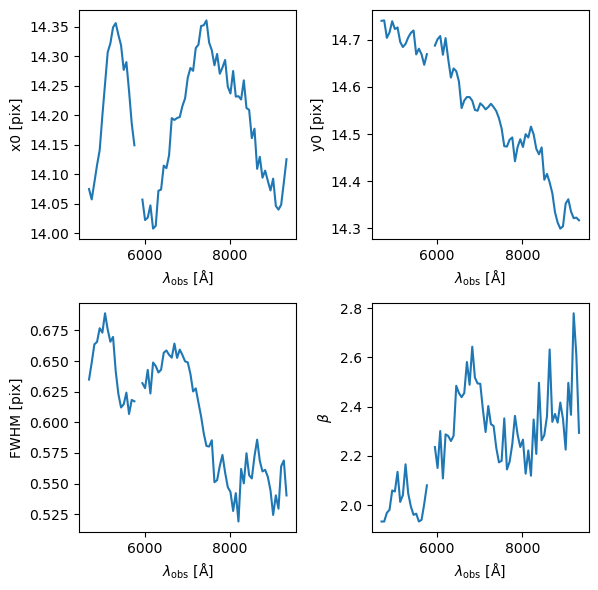

In [55]:
z_arr, par_arr = np.arange(0, np.shape(cube)[0], z_fitstep), np.array(par_list)


wl_obs = (z_arr - (header['CRPIX3']-1)) * header['CD3_3'] + header['CRVAL3']               
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
   
ax[0,0].plot(wl_obs, par_arr[:,0])
ax[0,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,0].set_ylabel('x0 [pix]')

ax[0,1].plot(wl_obs, par_arr[:,1])
ax[0,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,1].set_ylabel('y0 [pix]')


ax[1,0].plot(wl_obs, par_arr[:,3]*0.2)
ax[1,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,0].set_ylabel('FWHM [pix]')
#ax[1,0].legend(frameon=False)

ax[1,1].plot(wl_obs, par_arr[:,4])
ax[1,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,1].set_ylabel(r'$\beta$')

fig.tight_layout()
plt.show()

### Interpolate FWHM and beta

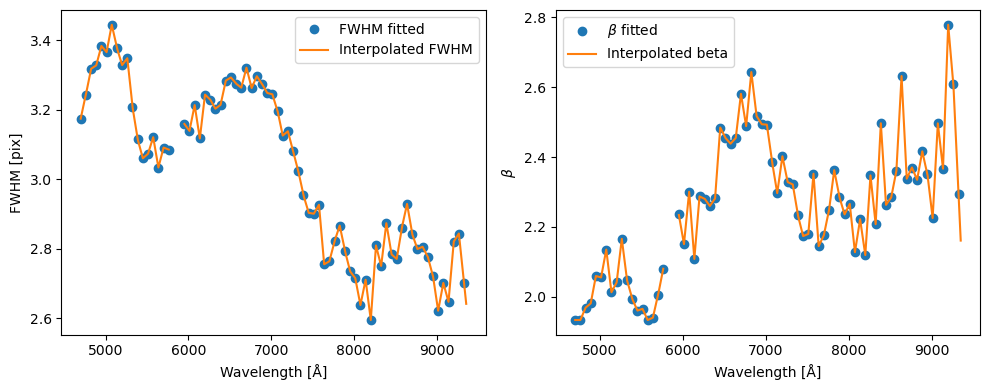

In [53]:
from scipy.interpolate import interp1d


z_arr = np.arange(0, cube.shape[0], z_fitstep)
par_arr = np.array(par_list)
fwhm_vals = par_arr[:, 3]
beta_vals = par_arr[:, 4]

# Graficar los parámetros FWHM y beta ajustados y su interpolación
wl_obs_sub = (z_arr - (header['CRPIX3'] -1)) * header['CD3_3'] + header['CRVAL3']
full_wl_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] -1)) * header['CD3_3'] + header['CRVAL3']
f_interp = interp1d(z_arr, fwhm_vals, kind='linear', bounds_error=False, fill_value='extrapolate')
b_interp = interp1d(z_arr, beta_vals, kind='linear', bounds_error=False, fill_value='extrapolate')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(wl_obs_sub, fwhm_vals, 'o', label='FWHM fitted')
ax[0].plot(full_wl_obs, f_interp(np.arange(header['NAXIS3'])), '-', label='Interpolated FWHM')
ax[0].set_ylabel('FWHM [pix]')
ax[0].set_xlabel('Wavelength [Å]')
ax[0].legend()

ax[1].plot(wl_obs_sub, beta_vals, 'o', label=r'$\beta$ fitted')
ax[1].plot(full_wl_obs, b_interp(np.arange(header['NAXIS3'])), '-', label='Interpolated beta')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_xlabel('Wavelength [Å]')
ax[1].legend()

plt.tight_layout()
plt.show()

### Go trought wavelenght (QSO) using star psf

In [178]:
# Inicialización de listas para almacenar parámetros por fuente
x_fit_list = [[] for _ in range(Nsources)]
y_fit_list = [[] for _ in range(Nsources)]
flux_fit_list = [[] for _ in range(Nsources)]
fwhm_fit_list = [[] for _ in range(Nsources)]
beta_fit_list = [[] for _ in range(Nsources)]

# Parámetros iniciales
initial_guesses = np.array([
    [27.919120, 23.578430, 0.694135, 3.196297, 2.104049],
    [32.159181, 25.133712, 0.839981, 3.163697, 2.379327],
    [23.898267, 28.169255, 0.993171, 3.094371, 2.398522],
    [29.491854, 28.854480, 0.609408, 3.307899, 2.583371],
    [30.065869, 40.172504, 0.269234, 3.262459, 2.761125],
    [26.050496, 49.721804, 0.017482, 3.090589, 5.115214]
])

n_spectral = cube.shape[0]

# Recorrer eje espectral
for i in range(n_spectral):
    z = wave_obs[i]  # o usa tu variable de long. de onda si ya está definida
    
    image = cube[i, :, :]
    error = np.sqrt(vcube)[i, :, :]
    
    # Cutout por canal espectral
    cutout = Cutout2D(image, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    img = cutout.data
    cutout_err = Cutout2D(error, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    img_err = cutout_err.data

    del cutout, cutout_err
    
    szy, szx = np.shape(img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))
    
    mask = (img == 0) | (np.isnan(img))
    x_aux = x[~mask]
    y_aux = y[~mask]
    img_aux = img[~mask]
    img_err_aux = img_err[~mask]

    norm = np.nanmax(img_aux)
    img_aux /= norm
    img_err_aux /= norm

    mean, median, std = sigma_clipped_stats(img_aux * norm, sigma=3.0)
    img -= median
    
    # Parámetros para esta longitud de onda
    guess, up_bounds, lo_bounds = [], [], []

    for j in range(Nsources):
        print(j)
        x0, y0, flux0, _, _ = initial_guesses[j]
        fwhm = f_interp(z)
        beta = b_interp(z)

        guess += [x0, y0, flux0] + [fwhm, beta]
        up_bounds += [x0 + 10, y0 + 10, flux0 * 1.5, fwhm * 1.05, beta * 1.05]
        lo_bounds += [x0 - 10, y0 - 10, flux0 * 0.01, fwhm * 0.95, beta * 0.95]

        for lo, up, g in zip(lo_bounds, up_bounds, guess):
            if lo >= up:
                print(f"Problema: lo={lo}, up={up}, guess={g}")


    try:
        popt, pcov = curve_fit(lens_qso_fit,
                               (x, y),
                               img_aux.ravel(),
                               p0=guess,
                               sigma=img_err_aux.ravel(),
                               bounds=(lo_bounds, up_bounds),
                               maxfev=10000)
    except RuntimeError:
        print(f"Ajuste falló en z = {z:.2f}")
        continue

    # Guardar parámetros ajustados para cada fuente
    for j in range(Nsources):
        x_fit_list[j].append(popt[j*5 + 0])
        y_fit_list[j].append(popt[j*5 + 1])
        flux_fit_list[j].append(popt[j*5 + 2])
        fwhm_fit_list[j].append(popt[j*5 + 3])
        beta_fit_list[j].append(popt[j*5 + 4])


0
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
1
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
2
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.02

ValueError: Each lower bound must be strictly less than each upper bound.